In [1]:
import numpy as np
from numpy import matlib
import math as mt
import cmath
import matplotlib.pyplot as plt
import pylab

In [2]:
#APPLIED CONSTANTS
angstrom = 10**(-10) #meters
eV = 1.602 * 10**(-19) #Joules
hbar = 1.0546 * 10**(-34) #in J
#hbar = 6.582 * 10**(-16) # eV*s
q = 1.602 * 10**(-19) #electron charge
me = 9.109 * 10**(-31)

#PARAMETERS
#applied voltage
voltage = 0.0
#energy of a tunnelling electron
#energy = 0.365*eV + voltage*q #energy under consideration, GaAs has Fermi energy around 0.005 eV


In [3]:
#EFFECTIVE MASS VARIES
#wells and barriers
b2_1=Barrier(5*angstrom, 0.5*eV, 5, 0.106*me)
w2_1=Well(50*angstrom, 0.0, 5, 0.067*me)
b2_2=Barrier(5*angstrom, 0.5*eV, 5, 0.106*me)
#array for the system
system2 = [b2_1, w2_1, b2_2]

b3_1=Barrier(5*angstrom, 0.5*eV, 5, 0.106*me)
w3_1=Well(20*angstrom, 0.0, 5, 0.067*me)
b3_2=Barrier(5*angstrom, 0.5*eV, 5, 0.106*me)
#array for the system
system3 = [b3_1, w3_1, b3_2]

e2_array = np.arange(0.05, 1.5, 5.5*10**(-4))
#print(e_array)
T2_array = []
for e in e2_array:
    T = find_T(e*eV, 0.0, system2, 0.067*me, 0.067*me)
    T2_array.append(T)
    
T3_array = []
for e in e2_array:
    T = find_T(e*eV, 0.0, system3, 0.067*me, 0.067*me)
    T3_array.append(T)
    
 
b4_1=Barrier(5*angstrom, 0.5*eV, 5, 0.106*me)
w4_1=Well(70*angstrom, 0.0, 5, 0.067*me)
b4_2=Barrier(5*angstrom, 0.5*eV, 5, 0.106*me)
#array for the system
system4 = [b4_1, w4_1, b4_2]

#e2_array = np.arange(0.05, 1.5, 5.5*10**(-4))
#print(e_array)
T4_array = []
for e in e2_array:
    T = find_T(e*eV, 0.0, system4, 0.067*me, 0.067*me)
    T4_array.append(T)
    

    
#print (T_array)
#plt.plot(e1_array, T1_array, 'b--', label='effective mass does not vary')
plt.plot(e2_array, T2_array, label='well width: 50 Angstroms')
plt.plot(e2_array, T3_array, label='well width: 20 angstroms')
plt.plot(e2_array, T4_array, label='well width: 70 angstroms')
plt.xlabel('Energy (eV)')
plt.ylabel('T')
plt.legend()
#plt.yscale('log')
plt.show()

NameError: name 'Barrier' is not defined

In [ ]:
#print (T_array)
plt.plot(e2_array, T1_array, 'b--', label='effective mass does not vary')
plt.plot(e2_array, T2_array, label='effective mass varies')
plt.xlabel('Energy (eV)')
plt.ylabel('T')
plt.legend()
#plt.yscale('log')
#plt.show()

In [60]:
#class for the system
class System(object):
    def __init__(self):
        self.sys = []
        self.app_volt = 0.0 
        
    def add_system_object(self, new_object):
        self.sys.append(new_object)
        
    def find_sys_length(self):
        # sum of the length arrays
        l = 0
        for i in range(1,len(self.sys)-1):
            l = l + np.sum(self.sys[i].width_array)
        return l
        
    def find_transmission_coefficient(self, E):
        E = E + self.app_volt
        #initialising system matrix
        sys_mat = np.matlib.identity(2)
        #loop over all the system elements
        for i in range(1,len(self.sys)+1):
            obj = self.sys[i-1]
            obj_mat = obj.find_total_obj_matrix(obj.width_array, obj.height_array, E)
            sys_mat = np.dot(sys_mat, obj_mat)

            if i == len(self.sys):
                break
            # enters the next object
            obj_next = self.sys[i]
            #finding wave vectors on the boundary of two objects
            k_obj = obj.find_wave_vector(E, obj.height_array[len(obj.height_array)-1])
            k_next = obj_next.find_wave_vector(E, obj_next.height_array[0])                            
            #connecting to sys objects with discontinuity matrix
            boundary_disc_mat = DiscontinuityMatrix(k_obj, k_next, obj.mass, obj_next.mass).disc_mat

            sys_mat = np.dot(sys_mat, boundary_disc_mat)
            boundary_prop_mat = PropagationMatrix(k_next, obj_next.width_array[0]).prop_mat
            sys_mat = np.dot(sys_mat, boundary_prop_mat)
        return 1 / ((abs(sys_mat[0, 0])) ** 2)
    
    #def apply_lin_voltage(self, V, inc=):
        #self.app_volt = V
        

In [61]:
#class representing system object (either well or barrier)
class SysObject(object):
    def __init__(self, obj_type, width, width_array, height_array, m_effective):
        self.obj_type = obj_type
        self.total_width = width
        self.width_array = width_array
        self.height_array = height_array
        self.mass = m_effective
        
    def find_wave_vector(self, E, V):
        if E > V:
            return complex(mt.sqrt(2*self.mass*abs(E-V))/hbar, 0)
        elif E < V:
            return complex(0, mt.sqrt(2*self.mass*abs(E-V))/hbar)

    #function for finding the total propagation matrix through the object
    def find_total_obj_matrix(self, width_array, height_array, E):
        #initialising system matrix
        sys_mat_local = np.matlib.identity(2)
        
        #looping over the system object
        for i in range(len(width_array)-1):
            #discontinuity matrix
            k_a = self.find_wave_vector(E, height_array[i])
            k_b = self.find_wave_vector(E, height_array[i+1]) 
            disc_mat_local = DiscontinuityMatrix(k_a, k_b, self.mass, self.mass).disc_mat
            #ipdate system matrix
            sys_mat_local = np.dot(sys_mat_local, disc_mat_local)            
            #propagation matrix
            prop_mat_local = PropagationMatrix(k_b, width_array[i+1]).prop_mat
            #update system matrix
            sys_mat_local = np.dot(sys_mat_local, prop_mat_local)
        return sys_mat_local
                  

class SysObjSpecified(SysObject):
    def __init__(self, obj_type, width_array, height_array, m_effective):
        super(SysObjSpecified, self).__init__(obj_type, sum(width_array), width_array, height_array, m_effective)
        assert len(width_array) == len(height_array), 'width_array and height_array need to have same lengths'        
        #self.width_array = width_array
        #self.height_array = height_array
        
class SquareBarrier(SysObject):
    def __init__(self, obj_type, width, height, m_effective):
        # dividing barrier into bits for functions to work
        self.width_array = np.array([width/2., width/2.])
        self.height_array = np.array([height, height])
        super(SquareBarrier, self).__init__(obj_type, width, self.width_array, self.height_array, m_effective)
        
class RoundBarrier(SysObject):
    def __init__(self, obj_type, width, min_height, max_height, divisions, m_effective):
        self.min_height = min_height
        self.max_height = max_height
        self.barrier_width = width
        self.divs = divisions
        self.width_array = self.construct_width_array()
        self.height_array = self.construct_height_array()
        super(RoundBarrier, self).__init__(obj_type, width, self.width_array, self.height_array, m_effective)
        
    def construct_width_array(self):
        return [self.barrier_width/self.divs for i in range(self.divs)]
        
    def construct_height_array(self):
        h_max = self.max_height
        h_min = self.min_height
        diff = h_max - h_min
        divs = self.divs
        h_arr = []
        if divs % 2 == 1:
            print ('odd')
            inc = diff/((divs-1)/2)
            h_arr.append(h_max)
            for i in reversed(range(int((divs-1)/2))):
                h_arr.insert(0, h_min + i * inc)
                h_arr.append(h_min + i * inc)
        else:
            print('even')
            inc = diff/((divs-2)/2)
            h_arr = [h_max, h_max]
            for i in reversed(range(int(divs/2)-1)):
                h_arr.insert(0, h_min + i * inc)
                h_arr.append(h_min + i * inc)
        return h_arr

In [52]:
my_round_barrier = RoundBarrier('barrier', 10, 20, 32, 6, 2)
print(my_round_barrier.width_array)
print(my_round_barrier.height_array)

even
[1.6666666666666667, 1.6666666666666667, 1.6666666666666667, 1.6666666666666667, 1.6666666666666667, 1.6666666666666667]
[20.0, 26.0, 32, 32, 26.0, 20.0]


In [7]:
def find_transmission_coeff(system, E):
    #initialising system matrix
    sys_mat = np.matlib.identity(2)
    #loop over all the system elements
    for i in range(1,len(system.sys)+1):
        obj = system.sys[i-1]
        obj_mat = obj.find_total_obj_matrix(obj.width_array, obj.height_array, E)
        sys_mat = np.dot(sys_mat, obj_mat)
        
        if i == len(system.sys):
            break
        # enters the next object
        obj_next = system.sys[i]
        #finding wave vectors on the boundary of two objects
        k_obj = obj.find_wave_vector(E, obj.height_array[len(obj.height_array)-1])
        k_next = obj_next.find_wave_vector(E, obj_next.height_array[0])                            
        #connecting to sys objects with discontinuity matrix
        boundary_disc_mat = DiscontinuityMatrix(k_obj, k_next, obj.mass, obj_next.mass).disc_mat

        sys_mat = np.dot(sys_mat, boundary_disc_mat)
        boundary_prop_mat = PropagationMatrix(k_next, obj_next.width_array[0]).prop_mat
        sys_mat = np.dot(sys_mat, boundary_prop_mat)
    return 1 / ((abs(sys_mat[0, 0])) ** 2)
        

In [59]:
my_system = System()

widths_e = np.array([1.])*angstrom
heights_e = np.array([0.])*eV
widths1 = np.array([2.5, 2.5, 2.5, 2.5])*angstrom
heights1 = np.array([0.5, 0.5, 0.5, 0.5])*eV
widths2 = np.array([12.5, 12.5, 12.5, 12.5])*angstrom
heights2 = np.array([0., 0., 0., 0.])*eV
widths3 = np.array([2.5, 2.5, 2.5, 2.5])*angstrom
heights3 = np.array([0.5, 0.5, 0.5, 0.5])*eV
widths_c = np.array([1.])*angstrom
heights_c = np.array([0.])*eV

my_system.add_system_object(SysObjSpecified('emitter', widths_e, heights_e, 0.067*me))
my_system.add_system_object(SquareBarrier('barrier', 10*angstrom, 0.5*eV, 0.067*me))
my_system.add_system_object(SysObjSpecified('well', widths2, heights2, 0.067*me))
my_system.add_system_object(SysObjSpecified('barrier', widths3, heights3, 0.067*me))
my_system.add_system_object(SysObjSpecified('collector', widths_c, heights_c, 0.067*me))
print(my_system.sys[1].mass)

print(my_system.find_transmission_coefficient(0.08*eV))
print(my_system.find_sys_length())

6.103030000000001e-32
0.424986804538
1
[  5.00000000e-10   5.00000000e-10]
1e-09
2
[  1.25000000e-09   1.25000000e-09   1.25000000e-09   1.25000000e-09]
6e-09
3
[  2.50000000e-10   2.50000000e-10   2.50000000e-10   2.50000000e-10]
7e-09
7e-09


In [13]:
e1_array = np.arange(0.05, 1.5, 5.5 * 10 ** (-4))
#e1_array = np.arange(0.05*eV, 1.5*eV, 0.145*eV)
# print(e_array)
T1_array = []
for e in e1_array:
    T = find_transmission_coeff(my_system, e*eV)
    T1_array.append(T)

In [16]:
my_system_round = System()
my_system_round.add_system_object(SysObjSpecified('emitter', widths_e, heights_e, 0.067*me))
my_system_round.add_system_object(RoundBarrier('barrier', 10*angstrom, 0.3*eV, 0.5*eV, 35, 0.106*me))
my_system_round.add_system_object(SysObjSpecified('well', widths2, heights2, 0.067*me))
my_system_round.add_system_object(RoundBarrier('barrier', 10*angstrom, 0.3*eV, 0.5*eV, 35, 0.106*me))
my_system_round.add_system_object(SysObjSpecified('collector', widths_c, heights_c, 0.067*me))

T2_array = []
for e in e1_array:
    T = find_transmission_coeff(my_system_round, e*eV)
    T2_array.append(T)

odd
odd


In [17]:
my_system_var = System()

widths1 = np.array([5. for i in range(10)])*angstrom
heights1 = np.array([0.495, 0.5, 0.51, 0.49, 0.46, 0.51, 0.505, 0.485, 0.5, 0.47])*eV

widths3 = np.array([5. for i in range(10)])*angstrom
heights3 = np.array([0.49, 0.501, 0.52, 0.47, 0.5, 0.515, 0.505, 0.485, 0.5, 0.47])*eV
print(widths1)

my_system_var.add_system_object(SysObjSpecified('emitter', widths_e, heights_e, 0.067*me))
my_system_var.add_system_object(SysObjSpecified('barrier', widths1, heights1, 0.106*me))
my_system_var.add_system_object(SysObjSpecified('well', widths2, heights2, 0.067*me))
my_system_var.add_system_object(SysObjSpecified('barrier', widths3, heights3, 0.106*me))
my_system_var.add_system_object(SysObjSpecified('collector', widths_c, heights_c, 0.067*me))

T3_array = []
for e in e1_array:
    T = find_transmission_coeff(my_system_var, e*eV)
    T3_array.append(T)

[  5.00000000e-10   5.00000000e-10   5.00000000e-10   5.00000000e-10
   5.00000000e-10   5.00000000e-10   5.00000000e-10   5.00000000e-10
   5.00000000e-10   5.00000000e-10]


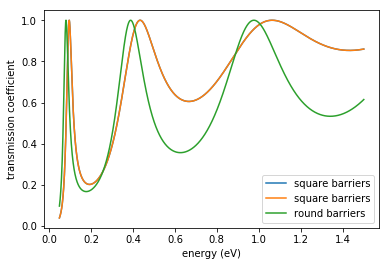

In [18]:
#print(T1_array)
plt.plot(e1_array, T1_array, label='square barriers')
plt.plot(e1_array, T2_array, label='round barriers')
#plt.plot(e1_array, T3_array, label='barriers with varuing height')
# plt.yscale('log')
plt.xlabel('energy (eV)')
plt.ylabel('transmission coefficient')
plt.legend()
plt.show()

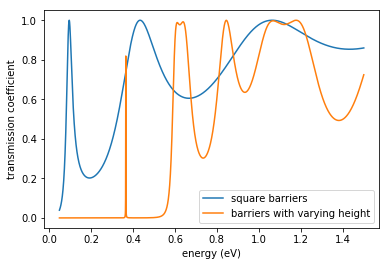

In [19]:
plt.plot(e1_array, T1_array, label='square barriers')
#plt.plot(e1_array, T2_array, label='round barriers')
plt.plot(e1_array, T3_array, label='barriers with varying height')
# plt.yscale('log')
plt.xlabel('energy (eV)')
plt.ylabel('transmission coefficient')
plt.legend()
plt.show()

In [10]:
# class representing barrier
class Barrier(object):
    def __init__(self, width, height, divisions, m_effective):
        self.width = width
        self.height = height
        self.div = divisions
        self.mass = m_effective


# class representing the well
class Well(object):
    def __init__(self, width, height, divisions, m_effective):
        self.width = width
        self.height = height
        self.div = divisions
        self.mass = m_effective



def wave_vector(m_effective, E, V):
    if E > V:
        return complex(mt.sqrt(2*m_effective*abs(E-V))/hbar, 0)
    elif E < V:
        return complex(0, mt.sqrt(2*m_effective*abs(E-V))/hbar)

In [10]:
class PropagationMatrix(object):
    def __init__(self, k_i, d):
        self.k_i = k_i
        self.width = d
        self.prop_mat = self.find_propagation_matrix()
        
        
    def find_propagation_matrix(self):
        #creating numpy matrix
        self.prop_mat = np.complex64(np.zeros((2, 2)))
        # assigning values to the matrix elements
        self.prop_mat[0, 0] = cmath.exp(complex(0, -1) * complex(self.width, 0) * self.k_i)
        self.prop_mat[1, 1] = cmath.exp(complex(0, 1) * complex(self.width, 0) * self.k_i)
        return self.prop_mat
 

In [11]:
   
class DiscontinuityMatrix(object):
    def __init__(self, k_i, k_f, m_i_effective, m_f_effective):
        self.rho = m_i_effective / m_f_effective * k_f / k_i
        self.disc_mat = self.find_discontinuity_matrix()
    
    def find_discontinuity_matrix(self):
        #creating numpy matrix
        self.disc_mat = np.complex64(np.zeros((2, 2)))
        # assigning values to the matrix elements
        self.disc_mat[0, 0] = 1. / 2. * (1 + self.rho)
        self.disc_mat[0, 1] = 1. / 2. * (1 - self.rho)
        self.disc_mat[1, 0] = 1. / 2. * (1 - self.rho)
        self.disc_mat[1, 1] = 1. / 2. * (1 + self.rho)
        return self.disc_mat

In [43]:
# function that finds the whole transmission coefficient
def find_T(energy, pot_diff, system, m_emitter, m_collector):
    # TODO: figure out how to represent non-zero applied voltage
    # wave vector before entering the first barrier, using the effective mass specified in the arguments
    k_emitter = wave_vector(m_emitter, energy, pot_diff)
    # wave vector in the first barrier
    k_first_barrier = wave_vector(system[0].mass, energy, pot_diff + system[0].height)
    # creating the discontinuity matrix between emitter and first barrier
    disc_mat_emitter = DiscontinuityMatrix(k_emitter, k_first_barrier, m_emitter, system[0].mass)
    # creating the system matrix and assigning the first discontinuity matrix to it
    sys_mat = disc_mat_emitter.disc_mat
    

    # looping over rest of the system
    for n in range(len(system)):
        # making the propagation matrix
        k_prop = wave_vector(system[n].mass, energy, pot_diff + system[n].height)
        prop_mat = PropagationMatrix(k_prop, system[n].width).prop_mat
        # adding this matrix to the system matrix
        sys_mat = np.dot(sys_mat, prop_mat)

        # stop after the propagation matrix for the last system element is done. Need to add final discontinuity matrix "manually"
        if n == len(system) - 1:
            break

        # wave number for the next item, needed for discontinuity matrix
        k_a = k_prop #renaming
        k_b = wave_vector(system[n + 1].mass, energy, pot_diff + system[n + 1].height)
        disc_mat = DiscontinuityMatrix(k_a, k_b, system[n].mass, system[n+1].mass).disc_mat
        #mat_disc = M_disc.mat_disc_effective(k_a, k_b)

        # multiplying into the system matrix
        sys_mat = np.dot(sys_mat, disc_mat)

    # the wave vector in the last barrier
    k_last_barrier = wave_vector(system[len(system) - 1].mass, energy, pot_diff + system[len(system) - 1].height)
    # wave vector on the right of the barrier-tunnel system
    k_collector = wave_vector(m_collector, energy, pot_diff)
    # discontinuity matrix connecting the last barrier and the region on the right of the barrier
    mat_disc_collector = DiscontinuityMatrix(k_last_barrier, k_collector, system[len(system) - 1].mass, m_collector).disc_mat

    # multiplying M_disc_f into the system matrix
    sys_mat = np.dot(sys_mat, mat_disc_collector)

    # transmission coefficient from the system matrix
    T = 1 / ((abs(sys_mat[0, 0])) ** 2)
    return T

In [148]:
# wells and barriers
b1_1 = Barrier(5 * angstrom, 0.5 * eV, 5, 0.067 * me)
w1_1 = Well(50 * angstrom, 0.0, 5, 0.067 * me)
b1_2 = Barrier(5 * angstrom, 0.5 * eV, 5, 0.067 * me)
w1_2=Well(50*angstrom, 0.0, 5, 0.067*me)
b1_3=Barrier(20*angstrom, 0.5*eV, 5, 0.067*me)
#array for the system
system1 = [b1_1, w1_1, b1_2]

#creating system for simulation
#system = System()
#system.add_system_object('barrier', 10 * angstrom, 0.5 * eV, 5, 0.067 * me)
#system.add_system_object('well', 50 * angstrom, 0.0 * eV, 5, 0.067 * me)
#system.add_system_object('barrier', 10 * angstrom, 0.5 * eV, 5, 0.067 * me)

                         
e1_array = np.arange(0.05, 1.5, 5.5 * 10 ** (-4))
# print(e_array)
T1_array = []
for e in e1_array:
    T = find_T(e * eV, 0.0, system.sys, 0.067 * me, 0.067 * me)
    T1_array.append(T)

# print (T_array)
plt.plot(e1_array, T1_array)
# plt.yscale('log')
plt.show()

IndexError: list index out of range